<a href="https://colab.research.google.com/github/kikiru328/All_about_Study/blob/main/EHAW/%EC%83%98%ED%94%8C%EC%A0%9C%EC%B6%9C%EC%99%84%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Load

In [1]:
import shutil
shutil.unpack_archive('/content/drive/MyDrive/EHAW_DATA.zip','/content/EHAW')

# Prediction

In [ ]:
import sys
sys.path.append('/content/')
import NEW_BONE as bone

In [ ]:
path ='/content/Sample/남/10431539.bmp'

In [ ]:
import os
import pandas as pd
import datetime as dt
data = pd.read_excel('/content/Sample/골연령측정자료220307.xlsx')
data = data.dropna()
data['Cage'] = data['Cage'].round(1)
data['Patient #'] = data['Patient #'].astype(int).astype(str)
patient_id = os.path.basename(path)[:-4]
display(data)
index = data[data['Patient #'] == patient_id].index[0]
# age = ((data['촬영일자']-data['생년월일'])/365)[1].days
gender = data[(data['Patient #'] == patient_id)]['sex'][index]
he = data[(data['Patient #'] == patient_id)]['촬영일키'][index]
year = data[(data['Patient #'] == patient_id)]['Cage'][index]

print(index)

,No,sex,생년월일,촬영일자,Cage,촬영일키,Patient #
1,103.0,M,1992-09-07,2004-05-19,11.7,138.0,97028583
2,106.0,M,1992-09-08,2004-08-04,11.9,143.0,10073987
3,101.0,M,1992-08-06,2003-09-17,11.1,137.5,96248548
4,107.0,M,1991-10-01,2003-09-17,12.0,135.8,10431539
5,111.0,M,1990-03-16,2002-09-24,12.5,149.9,96579259
6,115.0,M,1990-10-04,2003-07-23,12.8,150.7,10181949
7,117.0,M,1991-09-12,2004-11-17,13.2,146.1,96178702
8,121.0,M,1990-06-07,2004-01-28,13.6,167.0,10406334
9,124.0,M,1992-10-27,2006-10-25,14.0,152.5,10353946
10,127.0,M,1992-01-03,2006-11-29,14.9,160.3,10580752


4


In [ ]:
cv2_imshow(cv2.omre)

In [ ]:
path = '/content/Sample/남/10181949.bmp'
import time
import datetime
import sys
import os
import cv2
sys.path.append('/content/Bone/boneage')
import NEW_BONE as bone
import os
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import torch
import tensorflow.keras as tf
from google.colab.patches import cv2_imshow

def basic():
    model_path = '/content/Bone/boneage/weight/model.pt'
    tjnet_path = '/content/Bone/boneage/weight/tjnet24.h5'
    global tjnet
    tjnet = tf.models.load_model(tjnet_path, compile=False)
    global yolo
    yolo = torch.load(model_path, map_location='cpu')
    yolo.conf = 0.4
    return 

def data(path):
    data = pd.read_excel('/content/Sample/골연령측정자료220307.xlsx')
    data = data.dropna()
    data['Cage'] = data['Cage'].round(1)
    data['Patient #'] = data['Patient #'].astype(int).astype(str)
    patient_id = os.path.basename(path)[:-4]
    index = data[data['Patient #'] == patient_id].index[0]
    gender = data[(data['Patient #'] == patient_id)]['sex'][index]
    if 'F' in gender: 
        gender = 0
    else: gender = 1
    height = data[(data['Patient #'] == patient_id)]['촬영일키'][index]
    age = data[(data['Patient #'] == patient_id)]['Cage'][index]
    return patient_id, gender,height,age

def prediction(path,i):
    start = time.time()
    patient_id, gender, height, age = data(path)
    file_name = os.path.basename(path).replace('bmp','jpg')

    jpg_path = '/content/jpg/'
    if not os.path.exists(jpg_path):
        os.makedirs(jpg_path)

    processed_img = bone.Bone_extraction(path)


    cv2.imwrite(jpg_path+file_name,processed_img)

    crops, yoloimg, result = bone.yolo_crop_img(jpg_path+file_name,yolo)
    X = bone.out_crop_img(crops,gender)
    global prediction_BA
    prediction_BA = bone.predict_zscore(X, tjnet)
    prediction_BA = prediction_BA.round(2)
    lms_df = pd.read_csv('/content/Bone/boneage/data/height_df.csv')
    prediction_H = bone.Height_prediction(gender,prediction_BA,height,lms_df)

    diff = (prediction_BA - age).round(3)
    sec = time.time()-start
    times = str(datetime.timedelta(seconds=sec)).split(".")[0]
    print(times)
    csv = pd.DataFrame({'patient_id':patient_id,
                        'gender' : gender,
                        'actual_age':age,
                        'prediction_BA':prediction_BA,
                        'diff_age':diff,
                        'actual_height':height,
                        'prediction_H':prediction_H,
                        'code_time':times
                        },index=[i])


    if not os.path.exists('/content/Prediction.csv'):
        csv.to_csv('/content/Prediction.csv')
        print(f'save > {patient_id}')
    else:
        A = pd.read_csv('/content/Prediction.csv',index_col=0)
        A = A.append(csv)
        A.to_csv('/content/Prediction.csv')
        print(f'save > {patient_id}')
        

In [ ]:
basic()

In [ ]:
from glob import glob
from tqdm import tqdm
man = glob('/content/Sample/남/*.bmp')
female = glob('/content/Sample/여/*.bmp')

paths = man + female

error=[]
# print(paths)
for i, path in tqdm(enumerate(paths)):
    try:
        prediction(path,i)
    except:
        error.append(path)


1it [00:41, 41.60s/it]

0:00:41
save > 10353946


2it [01:17, 38.10s/it]

0:00:35
save > 10073987


3it [02:00, 40.51s/it]

0:00:43
save > 96579259


4it [02:47, 42.89s/it]

0:00:46
save > 10580752


5it [03:26, 41.71s/it]

0:00:39
save > 96178702


6it [04:08, 41.79s/it]

0:00:41
save > 10406334


7it [04:48, 41.15s/it]

0:00:39
save > 10181949


8it [05:23, 39.20s/it]

0:00:35
save > 97028583


10it [06:12, 33.00s/it]

0:00:40
save > 96248548


11it [06:48, 33.77s/it]

0:00:35
save > 10449372


12it [07:29, 36.09s/it]

0:00:41
save > 10499059


13it [08:08, 36.90s/it]

0:00:38
save > 10492817


14it [08:46, 37.25s/it]

0:00:38
save > 10152359


15it [09:23, 37.32s/it]

0:00:37
save > 10500378


16it [09:31, 28.22s/it]

0:00:07
save > 94383197


18it [10:19, 26.26s/it]

0:00:47
save > 10453605


19it [11:02, 30.62s/it]

0:00:43
save > 10391057


20it [11:48, 34.55s/it]

0:00:45
save > 10628162


21it [12:28, 35.66s/it]

0:00:40
save > 10267473


In [ ]:
def error_check(path):
    start = time.time()
    patient_id, gender, height, age = data(path)

    print('#####################')
    print(f'patient_id > {patient_id}' )
    print(f'gender > {gender}' )
    print(f'age > {age}' )
    print('#####################')
    file_name = os.path.basename(path).replace('bmp','jpg')
    patient_name = os.path.basename(path)[:-4]

    jpg_path = '/content/jpg/'
    if not os.path.exists(jpg_path):
        os.makedirs(jpg_path)

    processed_img = bone.Bone_extraction(path)


    cv2.imwrite(jpg_path+file_name,processed_img)

    crops, yoloimg, result = bone.yolo_crop_img(jpg_path+file_name,yolo)
    cv2_imshow(yoloimg)

In [ ]:

data = pd.read_excel('/content/Sample/골연령측정자료220307.xlsx')
data = data.dropna()
data['Cage'] = data['Cage'].round(1)
data['Patient #'] = data['Patient #'].astype(int).astype(str)
patient_id = os.path.basename('/content/Sample/여/10402104.bmp')[:-4]
index = data[data['Patient #'] == patient_id].index[0]
gender = data[(data['Patient #'] == patient_id)]['sex'][index]
if 'F' in gender: 
    gender = 0
else: gender = 1
height = data[(data['Patient #'] == patient_id)]['촬영일키'][index]
age = data[(data['Patient #'] == patient_id)]['Cage'][index]


IndexError: ignored

In [ ]:
data

,No,sex,생년월일,촬영일자,Cage,촬영일키,Patient #
1,103.0,M,1992-09-07,2004-05-19,11.7,138.0,97028583
2,106.0,M,1992-09-08,2004-08-04,11.9,143.0,10073987
3,101.0,M,1992-08-06,2003-09-17,11.1,137.5,96248548
4,107.0,M,1991-10-01,2003-09-17,12.0,135.8,10431539
5,111.0,M,1990-03-16,2002-09-24,12.5,149.9,96579259
6,115.0,M,1990-10-04,2003-07-23,12.8,150.7,10181949
7,117.0,M,1991-09-12,2004-11-17,13.2,146.1,96178702
8,121.0,M,1990-06-07,2004-01-28,13.6,167.0,10406334
9,124.0,M,1992-10-27,2006-10-25,14.0,152.5,10353946
10,127.0,M,1992-01-03,2006-11-29,14.9,160.3,10580752


In [ ]:
error

['/content/Sample/남/10431539.bmp', '/content/Sample/여/10402104.bmp']

# Blend Altman

In [101]:
import pandas as pd
prediction = pd.read_csv('/content/EHAW/Prediction.csv')
prediction

,patient_id,gender,actual_age,prediction_BA,diff_age,actual_height,prediction_H,code_time
0,10353946,1,14.0,11.79,-2.21,152.5,176.8,0:00:41
1,10073987,1,11.9,10.79,-1.11,143.0,174.3,0:00:35
2,96579259,1,12.5,11.24,-1.26,149.9,177.5,0:00:43
3,10580752,1,14.9,14.76,-0.14,160.3,168.0,0:00:46
4,96178702,1,13.2,13.95,0.75,146.1,162.1,0:00:39
5,10406334,1,13.6,12.69,-0.91,167.0,183.1,0:00:41
6,10181949,1,12.8,12.08,-0.72,150.7,173.4,0:00:39
7,97028583,1,11.7,8.85,-2.85,138.0,180.2,0:00:35
8,96248548,1,11.1,10.43,-0.67,137.5,171.0,0:00:40
9,10449372,0,10.5,9.88,-0.62,129.0,153.0,0:00:35


In [112]:
# Check
import os
man = os.listdir('/content/EHAW/Sample/남')
female = os.listdir('/content/EHAW/Sample/여')
sample_people = man+female
Sample_ = []
for pa in sample_people:
    Sample_.append(pa.split('.bmp')[0])
len(Sample_)


21

In [116]:
from tqdm import tqdm
patient_list = list(prediction['patient_id'].astype(str))
len(patient_list)
NO_DATA = []
for Pat in tqdm(Patient):
    if Pat not in patient_list:
        NO_DATA.append(Pat)
    else:
        pass
print(f'\nNO_DATA >> {NO_DATA}')

100%|██████████| 21/21 [00:00<00:00, 142987.64it/s]


NO_DATA >> ['10431539', '10402104']


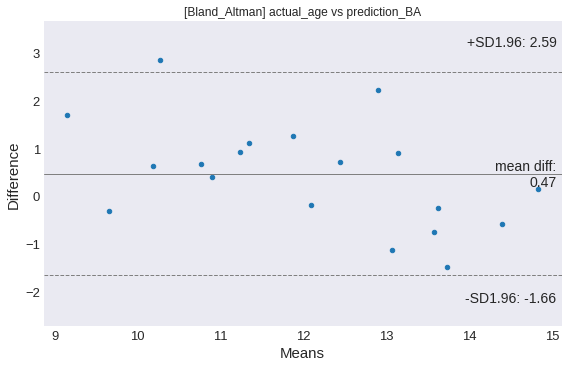

In [139]:
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-dark')
import statsmodels.api as sm
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, figsize = (8,5))
Blend_Altman = sm.graphics.mean_diff_plot(prediction['actual_age'],
                           prediction['prediction_BA'],
                           ax = ax)
plt.title('[Bland_Altman] actual_age vs prediction_BA')
plt.show(Blend_Altman)
# plt.imsave('/content/Blend_altman.png',Blend_Altman)

In [140]:
shutil.make_archive('/content/샘플제출','zip','/content/샘플제출')

'/content/샘플제출.zip'

In [141]:
shutil.copy('/content/샘플제출.zip','/content/drive/MyDrive/이화샘플제출.zip')

'/content/drive/MyDrive/이화샘플제출.zip'